# **Introdução**

Na competitiva indústria de telecomunicações dos dias de hoje, reter clientes é crucial para o sucesso empresarial. A perda de clientes (customer churn) pode impactar significativamente na receita e no crescimento de uma empresa.

Este projeto busca comparar diferentes técnicas de aprendizado de máquina que preveem se um cliente irá ou não se desligar de uma empresa. Isto será feito a partir de um [dataset](https://colab.research.google.com/drive/1f28GU-E3JSnDntbTm5goJfz3W52uxJOF#scrollTo=Z-jRcjSK2v2Z&line=3&uniqifier=1) que conta com diferentes atributos relacionados aos clientes de uma empresa fictícia de telecomunicações, tais como método de pagamento, custo do serviço, tipo de contrato, entre outros.

# **Bibliotecas**

In [87]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# **Preparação dos dados**

## Carregamento

In [88]:
dados = pd.read_csv('https://raw.githubusercontent.com/yurifernandes96/churn_prediction/refs/heads/main/src/data.csv')

dados.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Tratamento colunas binárias

In [89]:
# Tratando colunas binárias "Yes/No"
colunas_binarias = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']

# Aplicando a conversão para cada coluna
dados[colunas_binarias] = dados[colunas_binarias].map(lambda x: 1 if x == 'Yes' else 0)

# Tratando a coluna gender "Male/Female"
dados['gender'] = dados['gender'].map(lambda x: 1 if x == 'Male' else 0)

# dados.head()

## Tratamento demais colunas com Dummies

In [90]:
# Exemplo de coluna com 3 dummies
dados.groupby('MultipleLines').size().reset_index(name='count')

,MultipleLines,count
0,No,3390
1,No phone service,682
2,Yes,2971


In [91]:
dados = dados.join(pd.get_dummies(dados['MultipleLines'], dtype=int, prefix='MultipleLines'))
dados = dados.join(pd.get_dummies(dados['InternetService'], dtype=int, prefix='InternetService'))
dados = dados.join(pd.get_dummies(dados['OnlineSecurity'], dtype=int, prefix='OnlineSecurity'))
dados = dados.join(pd.get_dummies(dados['OnlineBackup'], dtype=int, prefix='OnlineBackup'))
dados = dados.join(pd.get_dummies(dados['DeviceProtection'], dtype=int, prefix='DeviceProtection'))
dados = dados.join(pd.get_dummies(dados['TechSupport'], dtype=int, prefix='TechSupport'))
dados = dados.join(pd.get_dummies(dados['StreamingTV'], dtype=int, prefix='StreamingTV'))
dados = dados.join(pd.get_dummies(dados['StreamingMovies'], dtype=int, prefix='StreamingMovies'))
dados = dados.join(pd.get_dummies(dados['Contract'], dtype=int, prefix='Contract'))
dados = dados.join(pd.get_dummies(dados['PaymentMethod'], dtype=int, prefix='PaymentMethod'))

# dados.head()

In [92]:
# Remoção das colunas originais a partir das quais foram criados os dummies
dados.drop(['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod'], axis=1, inplace=True)

# dados.head()

## Tratamento do tipo de dado de cada coluna

In [93]:
dados.dtypes

,0
customerID,object
gender,int64
SeniorCitizen,int64
Partner,int64
Dependents,int64
tenure,int64
PhoneService,int64
PaperlessBilling,int64
MonthlyCharges,float64
TotalCharges,object


In [94]:
# Elimina coluna do ID (irrelevante para o treinamento)
dados.drop('customerID', axis=1, inplace=True)

In [95]:
# Transforma a coluna 'TotalCharges' em um tipo numérico
dados['TotalCharges'] = pd.to_numeric(dados['TotalCharges'], errors='coerce')

In [96]:
# Checagem se todos registros estão validos
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 41 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   gender                                   7043 non-null   int64  
 1   SeniorCitizen                            7043 non-null   int64  
 2   Partner                                  7043 non-null   int64  
 3   Dependents                               7043 non-null   int64  
 4   tenure                                   7043 non-null   int64  
 5   PhoneService                             7043 non-null   int64  
 6   PaperlessBilling                         7043 non-null   int64  
 7   MonthlyCharges                           7043 non-null   float64
 8   TotalCharges                             7032 non-null   float64
 9   Churn                                    7043 non-null   int64  
 10  MultipleLines_No                         7043 no

In [97]:
'''A coluna 'TotalCharges' teve 9 valores nulos, isso ocorreu porque alguns registros
continham o caracter de espaço, não sendo possível a conversão para float'''

# Remoção dos registros em que 'TotalCharges' é nulo
dados.dropna(subset=['TotalCharges'], inplace=True)

# dados.info()

## Reordenação das colunas

In [98]:
# Passando a coluna 'Churn' para o final
dados = dados[[col for col in dados.columns if col != 'Churn'] + ['Churn']]

# dados.head()

## Tratamento de colunas redundantes

Existem colunas que são redundantes, ou seja, apenas repetem a informação já contida em outra coluna, como ocorre em 'InternetService_No' e 'OnlineSecurity_No Internet Service'. Vamos identificar essas colunas para eliminá-las

### Colunas binárias

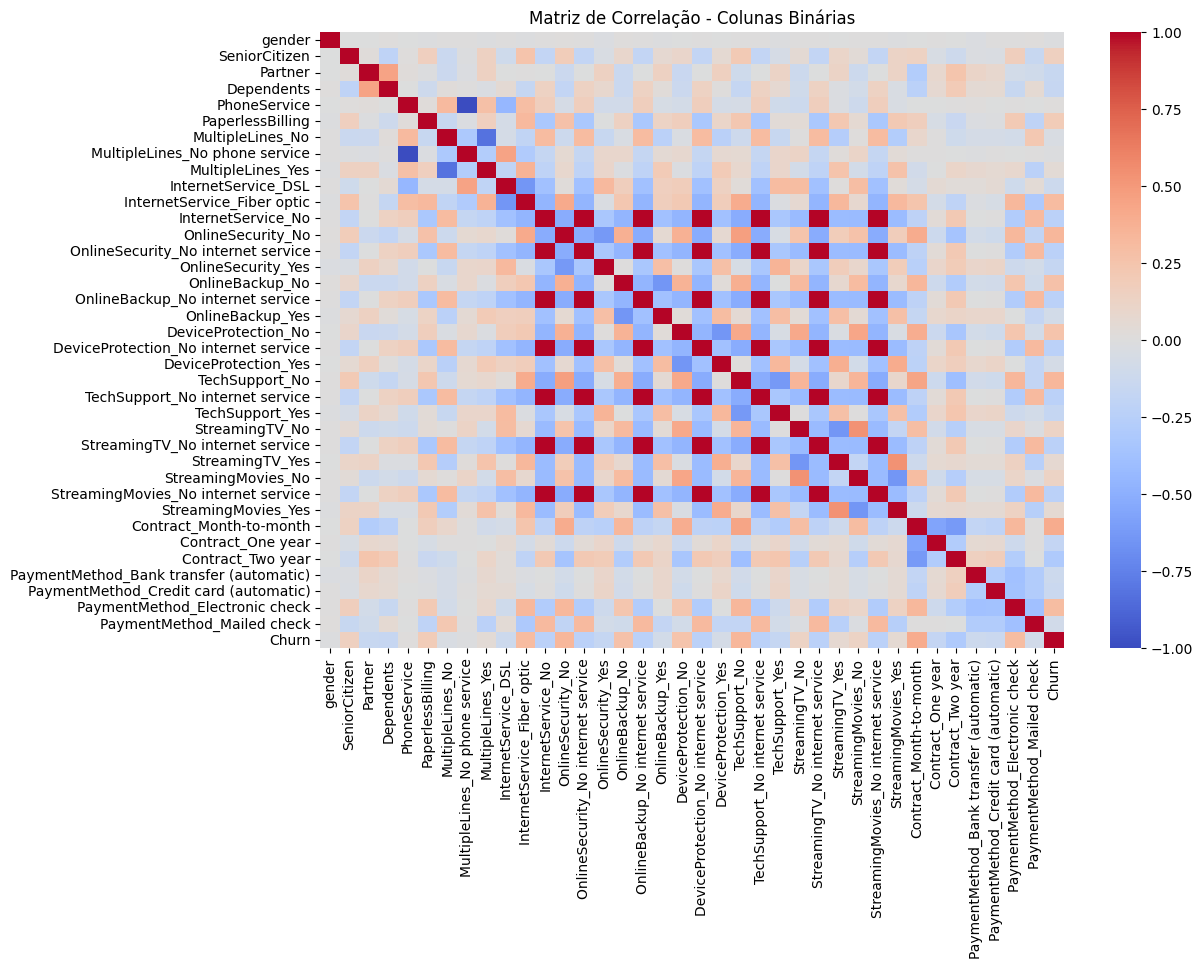

In [99]:
'''Embora a correlação de Pearson não possa ser aplicada para variáveis binárias,
vamos utiliza-lá apenas para identificação de pares de colunas idênticas ou opostas
(quando uma vale 0 a outra vale 1 e vice-versa), eliminando assim colunas cuja
correlação vale 1 ou -1'''

# Separação das colunas binárias
colunas_binarias = [col for col in dados.columns if dados[col].nunique() == 2]

# Matriz de correlação
correlacao_binaria = dados[colunas_binarias].corr()

# Plotar matriz de correlação para colunas binárias
plt.figure(figsize=(12, 8))
sns.heatmap(correlacao_binaria, annot=False, cmap='coolwarm', cbar=True)
plt.title("Matriz de Correlação - Colunas Binárias")
plt.show()

A partir da matriz de correlação das variáveis binárias, podemos eliminar as
colunas: 'OnlineSecurity_No Internet Service', 'OnlineBackup_No Internet Service',
'DeviceProtection_No Internet Service', 'TechSupport_No Internet Service',
'StreamingTV_No Internet Service' e 'StreamingMovies_No Internet Service', pois
são idênticas à coluna 'InternetService_No'

In [100]:
dados.drop(['OnlineSecurity_No internet service',
            'OnlineBackup_No internet service',
            'DeviceProtection_No internet service',
            'TechSupport_No internet service',
            'StreamingTV_No internet service',
            'StreamingMovies_No internet service'],
            axis=1, inplace=True)

Além disso, podemos eliminar a coluna 'MultipleLines_No phone service', pois possui correlação -1 com 'Phone Service'. Basicamente, a coluna 'Phone Service' já possui toda informação.

In [101]:
dados.drop(['MultipleLines_No phone service'], axis=1, inplace=True)

### Colunas não-binárias

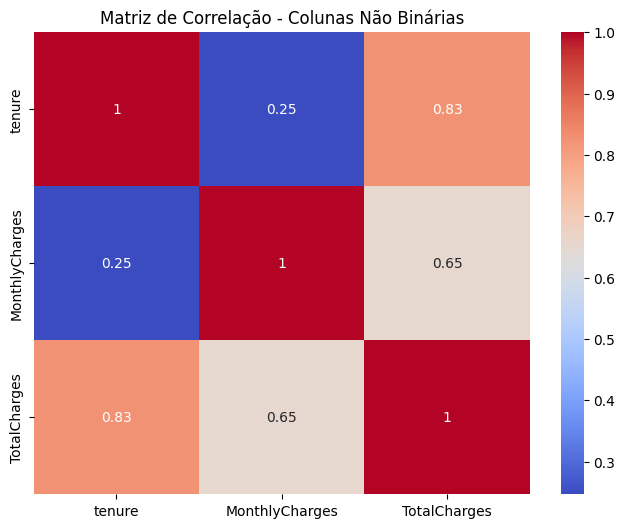

In [102]:
# Separação das colunas não-binárias
colunas_nao_binarias = [col for col in dados.columns if col not in colunas_binarias]

# Matriz de correlação
correlacao_nao_binaria = dados[colunas_nao_binarias].corr()

# Plotar matriz de correlação para colunas não binárias
plt.figure(figsize=(8, 6))
sns.heatmap(correlacao_nao_binaria, annot=True, cmap='coolwarm', cbar=True)
plt.title("Matriz de Correlação - Colunas Não Binárias")
plt.show()


In [103]:
''' 'tenure' possui uma correlação elevada com 'TotalCharges'. Na verdade,
a coluna 'TotalCharges' é uma combinação linear de 'tenure' com 'MonthlyCharges' '''

teste = dados['tenure'] * dados['MonthlyCharges']
teste.corr(dados['TotalCharges'])

0.9995598572867936

In [104]:
# A coluna 'TotalCharges' é irrelevante
dados.drop('TotalCharges', axis=1, inplace=True)

## Coluna 'Gender'

Por experiência de domínio, devemos analisar se a coluna 'Gender' exerce algum impacto na variável 'Churn', levando em conta que o sexo de uma pessoa não deveria impactar na sua decisão de cancelar ou não o serviço.

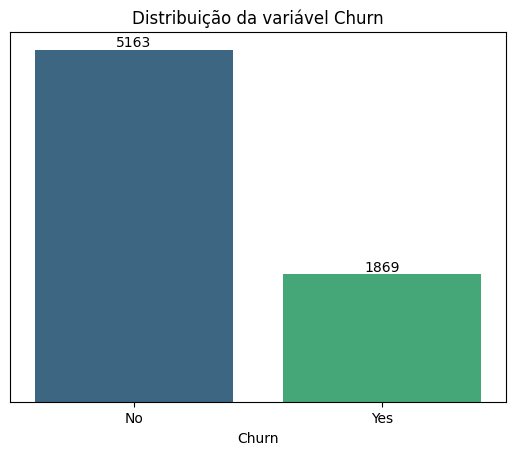

In [105]:
ax = sns.countplot(data=dados, x='Churn', hue='Churn', palette='viridis', legend=False)
ax.set_xticks([0, 1])
ax.set_xticklabels(['No', 'Yes'])
ax.get_yaxis().set_visible(False)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Distribuição da variável Churn')
plt.show()

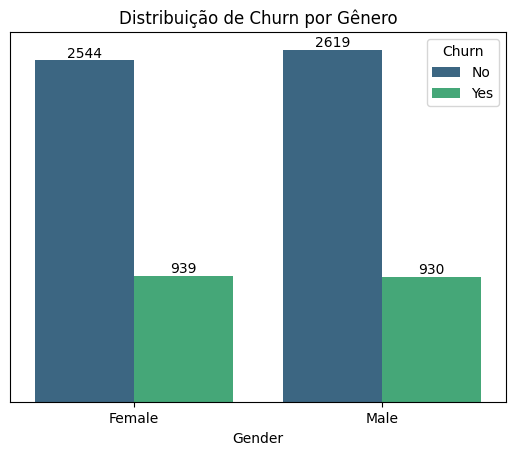

In [106]:
ax = sns.countplot(data=dados, x='gender', hue='Churn', palette='viridis')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Female', 'Male'])
ax.legend(title='Churn', labels=['No', 'Yes'])
ax.get_yaxis().set_visible(False)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Distribuição de Churn por Gênero')
plt.xlabel('Gender')
plt.show()

Podemos identificar que a Coluna "gender" não possui impacto no churn, uma vez que a proporção de pessoas que cancelaram o serviço é praticamente a mesma independente do gênero.

In [107]:
dados.drop('gender', axis=1, inplace=True)

## Dataset pronto

In [108]:
dados.to_csv('dados_tratados.csv', index=False)

dataset = dados.copy()

dataset.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,MultipleLines_No,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,0,1,0,1,0,1,29.85,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0
1,0,0,0,34,1,0,56.95,1,0,1,0,0,0,1,1,0,0,1,1,0,1,0,1,0,0,1,0,0,0,0,1,0
2,0,0,0,2,1,1,53.85,1,0,1,0,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,0,1,1
3,0,0,0,45,0,0,42.30,0,0,1,0,0,0,1,1,0,0,1,0,1,1,0,1,0,0,1,0,1,0,0,0,0
4,0,0,0,2,1,1,70.70,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,1


# **Regressão Logística**

A regressão logística é um método popular para prever uma resposta categórica. É um caso especial de modelos Lineares Generalizados que prevê a probabilidade dos resultados. A regressão logística pode ser usada para prever um resultado binário usando regressão logística binomial ou pode ser usada para prever um resultado multiclasse usando regressão logística multinomial.

<font size=2>**Fonte:** [Medium](https://medium.com/@nara.guimaraes/regress%C3%A3o-log%C3%ADstica-como-usu%C3%A1-la-em-an%C3%A1lise-de-dados-3fdb6be3a255)</font>

 <img src="https://raw.githubusercontent.com/yurifernandes96/churn_prediction/refs/heads/main/imgs/lr.gif">

In [109]:
# Separando variáveis preditoras (X) e alvo (y)
X = dataset.drop(columns=['Churn'])
y = dataset['Churn']

# Dividindo os dados em conjuntos de treino (70%) e teste (30%)
'''Note que devemos usar o parâmetro stratify=y devido ao desbalanceamento das classes
na variável 'Churn'. Graças a este parâmetro, podemos manter a mesma proporção de Yes/No
tanto no conjunto de treino quanto no conjunto de teste.'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Criando e treinando o modelo de regressão logística
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)

# Realizando predições no conjunto de teste
y_pred = logistic_model.predict(X_test)

# Avaliando o modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Acurácia: {accuracy:.4f}")
print("Relatório de Classificação:")
print(report)

Acurácia: 0.8038
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1549
           1       0.65      0.56      0.60       561

    accuracy                           0.80      2110
   macro avg       0.75      0.73      0.74      2110
weighted avg       0.80      0.80      0.80      2110



Uma métrica muito importante para a empresa é a quantidade de falsos-negativos, ou seja, a quantidade de clientes que pretendem cancelar o serviço mas que o modelo previu que não vão cancelar o serviço. Para este problema, queremos encontar um modelo em que este valor seja o menor possível.

Na prática, buscamos um modelo com a maior proporção de verdadeiros-positivos (recall da classe 1), pois isso significa que a taxa de falsos-negativos é menor.

In [110]:
def matriz_de_confusao(y_test, y_pred):
  m = confusion_matrix(y_test, y_pred)
  print(' '*25, 'Previsto')
  print(' '*18, 'Não-Churn', ' '*5 ,'Churn')
  print(' '*4, 'Não-Churn', ' '*6, int(m[0][0]), ' '*8, int(m[0][1]))
  print('Real')
  print(' '*8, 'Churn', ' '*6, int(m[1][0]), ' '*9, int(m[1][1]))

In [111]:
matriz_de_confusao(y_test, y_pred)

                          Previsto
                   Não-Churn       Churn
     Não-Churn        1381          168
Real
         Churn        246           315


O número de verdadeiros-positivos para o conjunto de teste foi de 315, o que equivale a um recall de 56%, ou seja, dos 561 clientes que pretendem cancelar o serviço, o modelo identificou corretamente que 315 iriam cancelar, e classificou erroneamente que 246 (44%) não iriam cancelar.

# **Árvore de Decisão**

Uma árvore de decisão é uma estrutura gráfica hierárquica que lhe ajuda a examinar atentamente e a classificar precisamente um modelo. O conceito de árvore de decisão é selecionar splits que diminuem a impureza da distribuição de classes nos subconjuntos de instâncias resultantes. Ao mesmo tempo, a dominação de uma ou mais classes sobre outras classes aumenta.

<font size=2>**Fonte:** [IBM](https://www.ibm.com/docs/pt-br/db2/12.1?topic=building-decision-trees)</font>

 <img src="https://raw.githubusercontent.com/yurifernandes96/churn_prediction/refs/heads/main/imgs/dt.gif">

In [112]:
# Cria e treina a árvore de decisão
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = dt.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Acurácia: {accuracy:.4f}")
print("Relatório de Classificação:")
print(report)

Acurácia: 0.7161
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.82      0.79      0.80      1549
           1       0.47      0.50      0.49       561

    accuracy                           0.72      2110
   macro avg       0.64      0.65      0.64      2110
weighted avg       0.72      0.72      0.72      2110



In [113]:
matriz_de_confusao(y_test, y_pred)

                          Previsto
                   Não-Churn       Churn
     Não-Churn        1228          321
Real
         Churn        278           283


O número de verdadeiros-positivos para o conjunto de teste foi de 283, o que equivale a um recall de 50%, ou seja, dos 561 clientes que pretendem cancelar o serviço, o modelo identificou corretamente que 283 iriam cancelar, e classificou erroneamente que 278 (50%) não iriam cancelar, tendo um desempenho pior do que a Regressão Logística.

# **Random Forest**

O Random Forest nada mais é do que a criação de várias árvores de decisão, de maneira aleatória, formando o que podemos enxergar como uma floresta, onde cada árvore será utilizada na escolha do resultado final, em uma espécie de votação.

Com o modelo de machine learning devidamente criado, podemos apresentar novos dados e obter o resultado da previsão. Cada árvore criada irá apresentar o seu resultado, sendo que em problemas de regressão será realizada a média dos valores previstos, e esta média informada como resultado final, e em problemas de classificação o resultado que mais vezes foi apresentado será o escolhido.

<font size=2>**Fonte:** [Didática Tech](https://didatica.tech/o-que-e-e-como-funciona-o-algoritmo-randomforest/)</font>

In [114]:
# Cria e treina o modelo
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = rf.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Acurácia: {accuracy:.4f}")
print("Relatório de Classificação:")
print(report)

Acurácia: 0.7630
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      1549
           1       0.57      0.47      0.51       561

    accuracy                           0.76      2110
   macro avg       0.69      0.67      0.68      2110
weighted avg       0.75      0.76      0.76      2110



In [115]:
matriz_de_confusao(y_test, y_pred)

                          Previsto
                   Não-Churn       Churn
     Não-Churn        1345          204
Real
         Churn        296           265


O número de verdadeiros-positivos para o conjunto de teste foi de 265, o que equivale a um recall de 47%, ou seja, dos 561 clientes que pretendem cancelar o serviço, o modelo identificou corretamente que 265 iriam cancelar, e classificou erroneamente que 296 (53%) não iriam cancelar, tendo um desempenho pior do que a Regressão Logística e do que a Árvore de Decisão.

# **Otimização**

Uma tarefa importante em modelagens de machine learning é a melhoria do modelo através da otimização dos seus hiperparâmetros.

Neste problema, iremos aplicar a técnica de Cross Validation, que consiste em dividir o conjunto de treino em k dobras (folds) e fazer k iterações neste conjunto. A cada iteração, um dos folds é separado dos demais e será utilizado para validação dos parâmetros.

Ao final das iterações, os melhores parâmetros são selecionados e o modelo pode ser avaliado com o conjunto de teste.

 <img src="https://raw.githubusercontent.com/yurifernandes96/churn_prediction/refs/heads/main/imgs/grid_search_cross_validation.png">

## **Árvore de Decisão**

In [116]:
# Definição do modelo de Decision Tree
dt_cv = DecisionTreeClassifier(random_state=42)

# Definição do espaço de hiperparâmetros para otimização
param_grid = {
    'max_depth': [2, 5, 10],
    'max_features': [10, 32, 45],
}

# Configuração do Grid Search com validação cruzada (10 folds)
grid_search = GridSearchCV(
    estimator=dt_cv,
    param_grid=param_grid,
    scoring='recall',  # Avaliador equivalente
    cv=10,  # Número de folds
)

# Treinando o modelo com o conjunto de treino
grid_search.fit(X_train, y_train)

# Melhor modelo encontrado
best_model = grid_search.best_estimator_

# Avaliando no conjunto de teste
y_pred = best_model.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Acurácia: {accuracy:.4f}")
print("Relatório de Classificação:")
print(report)

Acurácia: 0.7327
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.88      0.74      0.80      1549
           1       0.50      0.71      0.59       561

    accuracy                           0.73      2110
   macro avg       0.69      0.73      0.69      2110
weighted avg       0.78      0.73      0.75      2110



In [117]:
grid_search.best_params_

{'max_depth': 2, 'max_features': 10}

In [118]:
matriz_de_confusao(y_test, y_pred)

                          Previsto
                   Não-Churn       Churn
     Não-Churn        1147          402
Real
         Churn        162           399


O número de verdadeiros-positivos para o conjunto de teste foi de 399, o que equivale a um recall de 71%, ou seja, dos 561 clientes que pretendem cancelar o serviço, o modelo identificou corretamente que 399 iriam cancelar, e classificou erroneamente que 162 (29%) não iriam cancelar, tendo um desempenho muito superior aos modelos anteriores que não utilizaram nenhuma técnica de ótimização.

## **Random Forest**

In [119]:
# Definição do modelo de Random Forest
rf_cv = RandomForestClassifier(random_state=42)

# Definição do espaço de hiperparâmetros para otimização
param_grid = {
    'max_depth': [2, 5, 10],
    'max_features': [10, 32, 45],
    'n_estimators': [10, 20, 50] # número de árvores
}

# Configuração do Grid Search com validação cruzada (10 folds)
grid_search = GridSearchCV(
    estimator=rf_cv,
    param_grid=param_grid,
    scoring='recall',  # Avaliador equivalente
    cv=10,
)

grid_search.fit(X_train, y_train)

# Melhor modelo encontrado
best_model = grid_search.best_estimator_

# Avaliando no conjunto de teste
y_pred = best_model.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Acurácia: {accuracy:.4f}")
print("Relatório de Classificação:")
print(report)

Acurácia: 0.7555
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1549
           1       0.53      0.61      0.57       561

    accuracy                           0.76      2110
   macro avg       0.69      0.71      0.70      2110
weighted avg       0.77      0.76      0.76      2110



In [120]:
grid_search.best_params_

{'max_depth': 2, 'max_features': 32, 'n_estimators': 10}

In [121]:
matriz_de_confusao(y_test, y_pred)

                          Previsto
                   Não-Churn       Churn
     Não-Churn        1249          300
Real
         Churn        216           345


O número de verdadeiros-positivos para o conjunto de teste foi de 345, o que equivale a um recall de 61%, ou seja, dos 561 clientes que pretendem cancelar o serviço, o modelo identificou corretamente que 345 iriam cancelar, e classificou erroneamente que 216 (39%) não iriam cancelar, tendo um desempenho inferior à árvore de decisão.

# **Conclusão**

A Regressão Logística foi o modelo que obteve a melhor acurácia dentre todos analisados. Porém, neste problema a métrica mais importante é o Recall da classe 1, sendo a árvore de decisão após ótimizaçao o melhor modelo obtido, com um recall de 71%.